In [1]:
# First, the necessary modules are imported
import json
import os
import re
import pandas
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import string

# Step 1: Dataset Importing
To replicate these steps, first grab the CIC-Darknet2020 Dataset at https://www.unb.ca/cic/datasets/darknet2020.html.
Then put the file in the working directory of this notebook.

In [2]:
# We then import the dataset into pandas and show the resulting dataframe below.
df = pandas.read_csv('Darknet.CSV')
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,0,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,Non-Tor,AUDIO-STREAMING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158611,10.8.8.246-224.0.0.252-55219-5355-17,10.8.8.246,55219,224.0.0.252,5355,17,22/05/2015 01:55:03 PM,411806,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
158612,10.8.8.246-224.0.0.252-64207-5355-17,10.8.8.246,64207,224.0.0.252,5355,17,22/05/2015 02:09:05 PM,411574,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
158613,10.8.8.246-224.0.0.252-61115-5355-17,10.8.8.246,61115,224.0.0.252,5355,17,22/05/2015 02:19:31 PM,422299,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
158614,10.8.8.246-224.0.0.252-64790-5355-17,10.8.8.246,64790,224.0.0.252,5355,17,22/05/2015 02:29:55 PM,411855,2,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP


In [3]:
# We also print every column, as we will need this for later.
for col in df.columns:
    print(col)

Flow ID
Src IP
Src Port
Dst IP
Dst Port
Protocol
Timestamp
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWE Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fw

# Step 2: Data Manipulation
Before this dataset is made into graphs, we first need to get our data optimized to work for this.

In [4]:
# We first properly convert the timestamps to panda's native format.
df['Timestamp'] = pandas.to_datetime(df['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
# Then create a rounded to the minute field for use later.
df['timestamp_minute'] = df['Timestamp'].dt.floor('min')
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1,timestamp_minute
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,2015-07-24 16:09:48,229,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING,2015-07-24 16:09:00
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,2015-07-24 16:09:48,407,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING,2015-07-24 16:09:00
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,2015-07-24 16:09:48,431,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING,2015-07-24 16:09:00
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,2015-07-24 16:09:48,359,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING,2015-07-24 16:09:00
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,2015-07-24 16:09:45,10778451,591,400,...,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,Non-Tor,AUDIO-STREAMING,2015-07-24 16:09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158611,10.8.8.246-224.0.0.252-55219-5355-17,10.8.8.246,55219,224.0.0.252,5355,17,2015-05-22 13:55:03,411806,2,0,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP,2015-05-22 13:55:00
158612,10.8.8.246-224.0.0.252-64207-5355-17,10.8.8.246,64207,224.0.0.252,5355,17,2015-05-22 14:09:05,411574,2,0,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP,2015-05-22 14:09:00
158613,10.8.8.246-224.0.0.252-61115-5355-17,10.8.8.246,61115,224.0.0.252,5355,17,2015-05-22 14:19:31,422299,2,0,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP,2015-05-22 14:19:00
158614,10.8.8.246-224.0.0.252-64790-5355-17,10.8.8.246,64790,224.0.0.252,5355,17,2015-05-22 14:29:55,411855,2,0,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP,2015-05-22 14:29:00


Once we have our minute rounded field, we now want to focus on a small subsection of the dataset to test graph creation. Specifically, we will work with the first 5 unique minutes in the dataset.

In [5]:
# Firstly, we sort the dataframe by timestamp earliest to latest...
df = df.sort_values(by=['Timestamp'])
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1,timestamp_minute
117476,131.202.240.150-131.202.243.255-138-138-17,131.202.240.150,138,131.202.243.255,138,17,2015-03-30 09:41:57,111893566,5,0,...,0,0,0,1.427719e+15,6.024434e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117563,131.202.240.150-131.202.244.3-48752-53-17,131.202.240.150,48752,131.202.244.3,53,17,2015-03-30 09:41:58,447,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117546,131.202.240.150-131.202.244.5-48752-53-17,131.202.240.150,48752,131.202.244.5,53,17,2015-03-30 09:41:58,340,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117458,131.202.240.150-173.252.100.27-56404-443-6,131.202.240.150,56404,173.252.100.27,443,6,2015-03-30 09:41:58,110452590,299,267,...,0,0,0,1.427719e+15,2.491754e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117487,131.202.240.150-131.202.6.3-48752-53-17,131.202.240.150,48752,131.202.6.3,53,17,2015-03-30 09:41:58,1184,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134885,10.0.2.15-195.154.107.23-36629-443-6,10.0.2.15,36629,195.154.107.23,443,6,2016-02-25 12:11:55,85152484,3025,2224,...,0,0,0,1.456417e+15,1.977393e+07,1.456417e+15,1.456417e+15,Tor,File-Transfer,2016-02-25 12:11:00
50906,10.152.152.11-91.190.218.56-38996-12350-6,10.152.152.11,38996,91.190.218.56,12350,6,2016-02-25 12:12:52,304611,2,2,...,0,0,0,1.456417e+15,2.152143e+05,1.456417e+15,1.456417e+15,Non-Tor,File-Transfer,2016-02-25 12:12:00
50908,10.152.152.11-157.56.126.124-56483-443-6,10.152.152.11,56483,157.56.126.124,443,6,2016-02-25 12:13:10,3385448,4,4,...,0,0,0,1.456417e+15,1.491082e+06,1.456417e+15,1.456417e+15,Non-Tor,File-Transfer,2016-02-25 12:13:00
50934,10.152.152.11-193.71.119.225-56607-22223-6,10.152.152.11,56607,193.71.119.225,22223,6,2016-02-25 12:13:17,1283122,8,9,...,0,0,0,1.456417e+15,3.760652e+05,1.456417e+15,1.456417e+15,Non-Tor,File-Transfer,2016-02-25 12:13:00


In [6]:
# Then we select the first 5 unique minutes in the dataset...
first_5_minutes = df['timestamp_minute'].drop_duplicates().head(5)
# and create a new dataset of just those entries.
filtered_df = df[df['timestamp_minute'].isin(first_5_minutes)]
filtered_df


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1,timestamp_minute
117476,131.202.240.150-131.202.243.255-138-138-17,131.202.240.150,138,131.202.243.255,138,17,2015-03-30 09:41:57,111893566,5,0,...,0,0,0,1.427719e+15,6.024434e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117563,131.202.240.150-131.202.244.3-48752-53-17,131.202.240.150,48752,131.202.244.3,53,17,2015-03-30 09:41:58,447,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117546,131.202.240.150-131.202.244.5-48752-53-17,131.202.240.150,48752,131.202.244.5,53,17,2015-03-30 09:41:58,340,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117458,131.202.240.150-173.252.100.27-56404-443-6,131.202.240.150,56404,173.252.100.27,443,6,2015-03-30 09:41:58,110452590,299,267,...,0,0,0,1.427719e+15,2.491754e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117487,131.202.240.150-131.202.6.3-48752-53-17,131.202.240.150,48752,131.202.6.3,53,17,2015-03-30 09:41:58,1184,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117600,131.202.240.150-131.202.244.3-9615-53-17,131.202.240.150,9615,131.202.244.3,53,17,2015-03-30 09:45:19,464,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:45:00
117510,131.202.240.150-131.202.244.5-9615-53-17,131.202.240.150,9615,131.202.244.5,53,17,2015-03-30 09:45:19,93618,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:45:00
117531,131.202.240.150-173.194.123.98-38626-443-6,131.202.240.150,38626,173.194.123.98,443,6,2015-03-30 09:45:23,25029,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:45:00
117564,131.202.240.150-131.202.244.3-32038-53-17,131.202.240.150,32038,131.202.244.3,53,17,2015-03-30 09:45:29,439,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:45:00


In [7]:
# And lastly, list the unique minute entries.
unique_minutes = filtered_df['timestamp_minute'].unique()
print(unique_minutes)

<DatetimeArray>
['2015-03-30 09:41:00', '2015-03-30 09:42:00', '2015-03-30 09:43:00',
 '2015-03-30 09:44:00', '2015-03-30 09:45:00']
Length: 5, dtype: datetime64[ns]


In [8]:
# We also group together the entries by the minute to see how large each graph should be.
grouped = filtered_df.groupby('timestamp_minute')
counts = grouped.size()
print(counts)

timestamp_minute
2015-03-30 09:41:00     12
2015-03-30 09:42:00    118
2015-03-30 09:43:00     19
2015-03-30 09:44:00     16
2015-03-30 09:45:00     13
dtype: int64


In [9]:
# And print the dataframe one last time.
filtered_df = filtered_df.sort_values(by='Timestamp', ascending=True)
print(filtered_df.to_string())

                                              Flow ID           Src IP  Src Port           Dst IP  Dst Port  Protocol           Timestamp  Flow Duration  Total Fwd Packet  Total Bwd packets  Total Length of Fwd Packet  Total Length of Bwd Packet  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean   Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean   Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Packet Length Min  Packet Length Max  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  CWE Flag Count  E

# Step 3: Graph Creation
Now that the dataframe has been properly filtered for testing purposes, I now will begin the creation of a graph.

In [10]:
# For testing, we grab only the first group of entries.
first_group_key = list(grouped.groups.keys())[0]
first_group = grouped.get_group(first_group_key)
first_group

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1,timestamp_minute
117476,131.202.240.150-131.202.243.255-138-138-17,131.202.240.150,138,131.202.243.255,138,17,2015-03-30 09:41:57,111893566,5,0,...,0,0,0,1.427719e+15,6.024434e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117563,131.202.240.150-131.202.244.3-48752-53-17,131.202.240.150,48752,131.202.244.3,53,17,2015-03-30 09:41:58,447,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117546,131.202.240.150-131.202.244.5-48752-53-17,131.202.240.150,48752,131.202.244.5,53,17,2015-03-30 09:41:58,340,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117458,131.202.240.150-173.252.100.27-56404-443-6,131.202.240.150,56404,173.252.100.27,443,6,2015-03-30 09:41:58,110452590,299,267,...,0,0,0,1.427719e+15,2.491754e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117487,131.202.240.150-131.202.6.3-48752-53-17,131.202.240.150,48752,131.202.6.3,53,17,2015-03-30 09:41:58,1184,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117547,131.202.240.150-131.202.244.5-13185-53-17,131.202.240.150,13185,131.202.244.5,53,17,2015-03-30 09:41:59,347,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00
117461,131.202.240.150-209.148.205.26-44701-443-6,131.202.240.150,44701,209.148.205.26,443,6,2015-03-30 09:41:59,117084492,44,45,...,0,0,0,1.427719e+15,2.121228e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117462,131.202.240.150-209.148.205.26-44700-443-6,131.202.240.150,44700,209.148.205.26,443,6,2015-03-30 09:41:59,117205336,11,9,...,0,0,0,1.427719e+15,4.090108e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117463,131.202.240.150-24.156.140.40-41069-443-6,131.202.240.150,41069,24.156.140.40,443,6,2015-03-30 09:41:59,116610010,7,4,...,0,0,0,1.427719e+15,4.857531e+07,1.427719e+15,1.427719e+15,NonVPN,Video-Streaming,2015-03-30 09:41:00
117477,131.202.240.150-131.202.244.5-13063-53-17,131.202.240.150,13063,131.202.244.5,53,17,2015-03-30 09:41:59,377,1,1,...,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NonVPN,Video-Streaming,2015-03-30 09:41:00


In [11]:
index = 0
G = nx.DiGraph()
previous_backward_node = None
for idx, row in first_group.iterrows():
    src_ip = row['Src IP']
    dst_ip = row['Dst IP']
    flow_id = row['Flow ID']

    forward_node = f"{index}_fwd"
    G.add_node(forward_node, ip=src_ip, direction="forward", **row.to_dict())

    backward_node = f"{index}_bkd"
    G.add_node(backward_node, ip=dst_ip, direction="backward", **row.to_dict())

    G.add_edge(forward_node, backward_node)
    if previous_backward_node is not None:
        G.add_edge(previous_backward_node, forward_node)
    previous_backward_node = backward_node

    index += 1

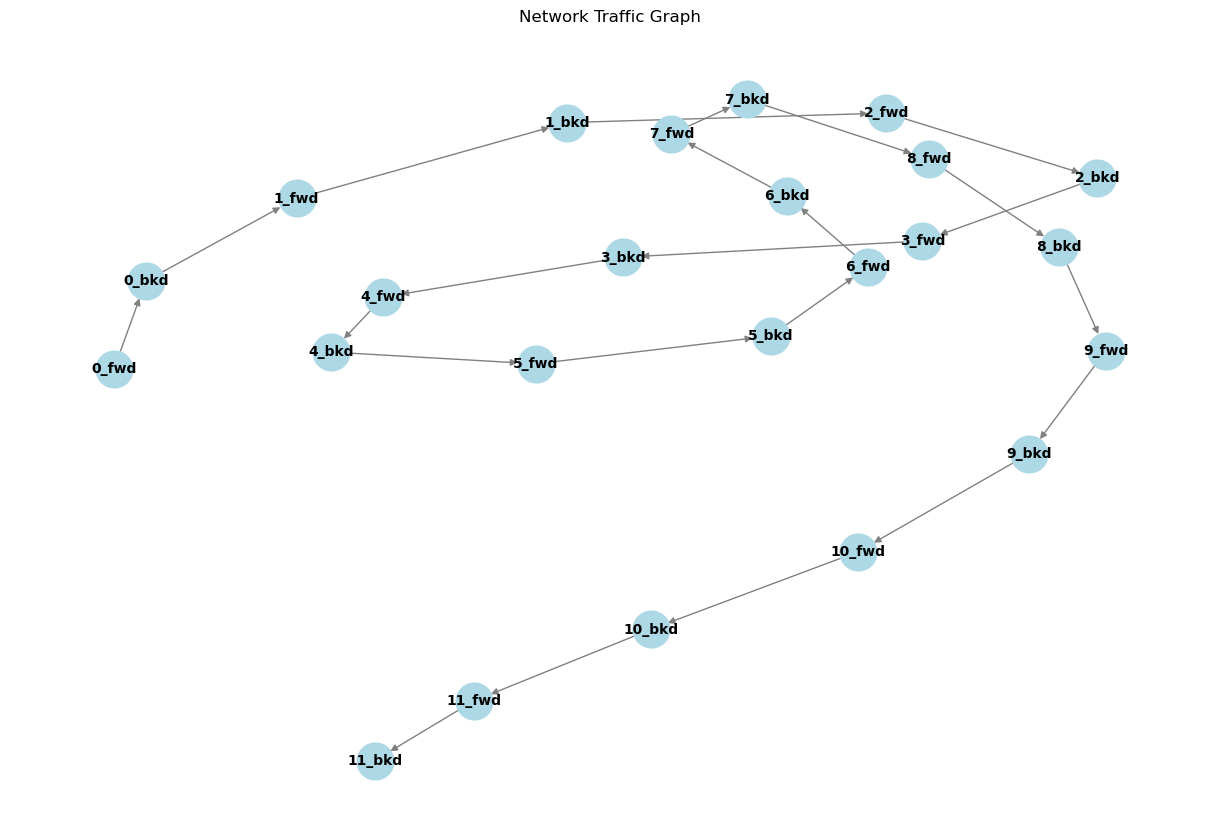

In [12]:
pos = nx.spring_layout(G) 
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Network Traffic Graph')
plt.show()
